In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from pymer4.models import Lmer
%matplotlib inline

# Deal with weekly predictions first

### data changes done in excel
- delete initials column
- delete duplicated row for 23952

In [2]:
wdat = pd.read_csv('../data/WeeksofDepressionDatasetforDylan.csv', index_col=0).reset_index(drop=True)

In [3]:
# make sure each subject is only in there once
assert len(wdat.groupby('SDAN')[['Participant_Type2']].count().query('Participant_Type2 > 1')) == 0
# make sure there aren't any nulls
assert wdat.isnull().sum().max() == 0
# make sure there are only MDDs in this group
assert wdat.Participant_Type2.unique()[0] == 'MDD'
# make sure there are only male and femal in the sex column
assert set(wdat.SEX.unique()) == {'FEMALE', 'MALE'}

In [4]:
wdat.dtypes

SDAN                                  int64
Participant_Type2                    object
SEX                                  object
Age_at_visit                        float64
Inpatient                             int64
BaselineAntiDep                       int64
BaselineOtherMeds                     int64
FUAntiDep                             int64
FUOtherMeds                           int64
dep_immed                             int64
BaselineMFQScore                    float64
s_case__neg_tot                       int64
c_ksadsdx_epset_annual_weeks_mdd      int64
dtype: object

In [5]:
wdat.describe()

,SDAN,Age_at_visit,Inpatient,BaselineAntiDep,BaselineOtherMeds,FUAntiDep,FUOtherMeds,dep_immed,BaselineMFQScore,s_case__neg_tot,c_ksadsdx_epset_annual_weeks_mdd
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,23792.680556,16.848194,0.263889,0.472222,0.319444,0.583333,0.305556,0.708333,11.759678,4.486111,21.486111
std,402.477847,1.342506,0.443833,0.502731,0.469533,0.496466,0.463875,0.457719,6.926224,3.918152,18.288758
min,22228.000000,12.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23666.000000,16.017500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,3.750000
50%,23827.500000,17.080000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,11.500000,4.000000,20.000000
75%,24064.250000,17.795000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,6.000000,36.750000
max,24264.000000,18.930000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.005000,22.000000,57.000000


In [6]:
wdat.loc[wdat.BaselineMFQScore == 0]

,SDAN,Participant_Type2,SEX,Age_at_visit,Inpatient,BaselineAntiDep,BaselineOtherMeds,FUAntiDep,FUOtherMeds,dep_immed,BaselineMFQScore,s_case__neg_tot,c_ksadsdx_epset_annual_weeks_mdd
23,24135,MDD,FEMALE,15.17,0,0,0,0,0,1,0.0,3,0
34,23937,MDD,FEMALE,16.42,0,0,0,0,0,1,0.0,8,0


In [7]:
models = ['c_ksadsdx_epset_annual_weeks_mdd ~ BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit',
          'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit',
          'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + dep_immed + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit',
          'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + (dep_immed*s_case__neg_tot) + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit',
          'c_ksadsdx_epset_annual_weeks_mdd ~ dep_immed + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit'
         ]

In [8]:
data = wdat.copy()
model = models[0]
def kfold_linear(data, model):
    kf = KFold(n_splits=5)
    fits = []
    reses = []
    for train_ind, test_ind in kf.split(data):
        mdl = smf.ols(model, data.loc[train_ind])
        fitted = mdl.fit()
        res = data.loc[test_ind, ['SDAN'] + [mdl.endog_names]].copy()
        res[f'{mdl.endog_names}_predicted'] = fitted.predict(data.loc[test_ind])
        reses.append(res)
        fits.append(fitted)
    reses = pd.concat(reses)
    return fits, reses

In [9]:
reses = []
for mix, model in enumerate(models):
    ffs, rrs = kfold_linear(data, model)
    rrs['model'] = mix
    reses.append(rrs)
reses = pd.concat(reses)

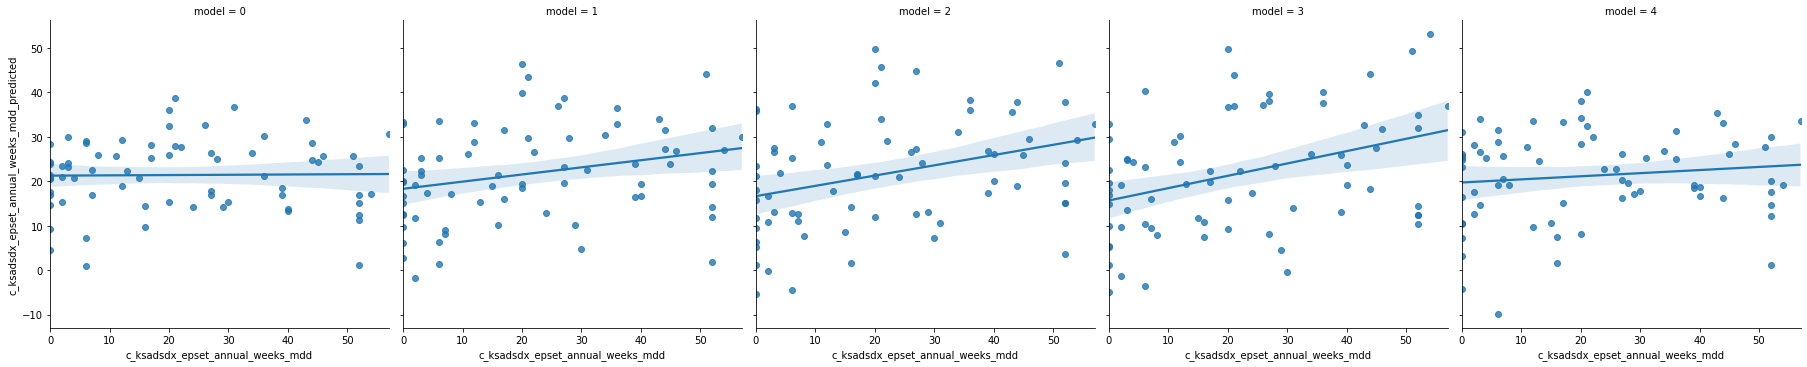

In [10]:
sns.lmplot(x='c_ksadsdx_epset_annual_weeks_mdd', y='c_ksadsdx_epset_annual_weeks_mdd_predicted', data=reses, col='model')

In [11]:
reses.to_csv('../data/weekly_cv_predictions.csv', index=None)

In [12]:
## fit models to everything
model = models[0]
mdl = smf.ols(model, data)
fitted = mdl.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.118
Model:                                          OLS   Adj. R-squared:                  0.022
Method:                               Least Squares   F-statistic:                     1.224
Date:                              Thu, 13 May 2021   Prob (F-statistic):              0.303
Time:                                      15:21:05   Log-Likelihood:                -306.39
No. Observations:                                72   AIC:                             628.8
Df Residuals:                                    64   BIC:                             647.0
Df Model:                                         7                                         
Covariance Type:                          nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.6494     27.411      0.097      0.923     -52.110      57.409
SEX[T.MALE]          -3.8641      5.000     -0.773      0.442     -13.852       6.124
BaselineAntiDep       0.5827      5.374      0.108      0.914     -10.153      11.318
BaselineOtherMeds   -10.1708      5.938     -1.713      0.092     -22.033       1.691
FUAntiDep             8.3107      5.354      1.552      0.126      -2.385      19.006
FUOtherMeds           1.8118      6.243      0.290      0.773     -10.660      14.284
Inpatient             6.6878      5.420      1.234      0.222      -4.141      17.517
Age_at_visit          0.9329      1.630      0.572      0.569      -2.323       4.189
==============================================================================
Omnibus:                        9.863   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                6.329
Skew:                           0.572   Prob(JB):                       0.0422
Kurtosis:                       2.105   Cond. No.                         219.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
## fit models to everything
model = models[1]
mdl = smf.ols(model, data)
fitted = mdl.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.268
Model:                                          OLS   Adj. R-squared:                  0.175
Method:                               Least Squares   F-statistic:                     2.889
Date:                              Thu, 13 May 2021   Prob (F-statistic):            0.00832
Time:                                      15:21:05   Log-Likelihood:                -299.66
No. Observations:                                72   AIC:                             617.3
Df Residuals:                                    63   BIC:                             637.8
Df Model:                                         8                                         
Covariance Type:                          nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             9.4137     25.234      0.373      0.710     -41.012      59.839
SEX[T.MALE]          -5.2002      4.605     -1.129      0.263     -14.402       4.002
BaselineMFQScore      1.1488      0.319      3.597      0.001       0.511       1.787
BaselineAntiDep       6.0416      5.161      1.171      0.246      -4.273      16.356
BaselineOtherMeds   -13.0777      5.511     -2.373      0.021     -24.090      -2.066
FUAntiDep             4.6911      5.017      0.935      0.353      -5.334      14.717
FUOtherMeds           2.1289      5.732      0.371      0.712      -9.325      13.583
Inpatient             2.4038      5.117      0.470      0.640      -7.821      12.629
Age_at_visit         -0.1596      1.527     -0.105      0.917      -3.211       2.892
==============================================================================
Omnibus:                        4.537   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.526
Skew:                           0.590   Prob(JB):                        0.104
Kurtosis:                       2.659   Cond. No.                         272.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
## fit models to everything
model = models[2]
mdl = smf.ols(model, data)
fitted = mdl.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.342
Model:                                          OLS   Adj. R-squared:                  0.247
Method:                               Least Squares   F-statistic:                     3.588
Date:                              Thu, 13 May 2021   Prob (F-statistic):            0.00121
Time:                                      15:21:05   Log-Likelihood:                -295.82
No. Observations:                                72   AIC:                             611.6
Df Residuals:                                    62   BIC:                             634.4
Df Model:                                         9                                         
Covariance Type:                          nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            17.2532     24.297      0.710      0.480     -31.315      65.821
SEX[T.MALE]          -5.2194      4.401     -1.186      0.240     -14.016       3.578
BaselineMFQScore      1.1667      0.305      3.822      0.000       0.556       1.777
dep_immed            11.2538      4.259      2.642      0.010       2.740      19.767
BaselineAntiDep       5.5292      4.936      1.120      0.267      -4.339      15.397
BaselineOtherMeds   -12.2847      5.275     -2.329      0.023     -22.829      -1.741
FUAntiDep             4.4317      4.795      0.924      0.359      -5.154      14.018
FUOtherMeds           1.9089      5.478      0.348      0.729      -9.042      12.860
Inpatient             2.0810      4.891      0.425      0.672      -7.696      11.859
Age_at_visit         -1.0929      1.501     -0.728      0.469      -4.094       1.908
==============================================================================
Omnibus:                        2.326   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.304
Skew:                           0.401   Prob(JB):                        0.316
Kurtosis:                       2.646   Cond. No.                         274.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
## fit models to everything
model = models[3]
mdl = smf.ols(model, data)
fitted = mdl.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.399
Model:                                          OLS   Adj. R-squared:                  0.288
Method:                               Least Squares   F-statistic:                     3.615
Date:                              Thu, 13 May 2021   Prob (F-statistic):           0.000597
Time:                                      15:21:05   Log-Likelihood:                -292.61
No. Observations:                                72   AIC:                             609.2
Df Residuals:                                    60   BIC:                             636.5
Df Model:                                        11                                         
Covariance Type:                          nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    20.3421     24.341      0.836      0.407     -28.347      69.031
SEX[T.MALE]                  -4.2839      4.322     -0.991      0.326     -12.929       4.361
BaselineMFQScore              0.9013      0.324      2.779      0.007       0.253       1.550
dep_immed                     7.6108      7.335      1.038      0.304      -7.062      22.283
s_case__neg_tot               0.4745      1.266      0.375      0.709      -2.057       3.006
dep_immed:s_case__neg_tot     0.8713      1.344      0.648      0.519      -1.818       3.560
BaselineAntiDep               5.1646      5.161      1.001      0.321      -5.160      15.489
BaselineOtherMeds           -10.5036      5.199     -2.020      0.048     -20.903      -0.105
FUAntiDep                     4.5618      4.957      0.920      0.361      -5.354      14.477
FUOtherMeds                   0.2368      5.376      0.044      0.965     -10.516      10.990
Inpatient                     4.0317      4.960      0.813      0.420      -5.890      13.954
Age_at_visit                 -1.2724      1.463     -0.870      0.388      -4.198       1.654
==============================================================================
Omnibus:                        2.956   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.228   Jarque-Bera (JB):                2.856
Skew:                           0.432   Prob(JB):                        0.240
Kurtosis:                       2.548   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
## fit models to everything
model = models[4]
mdl = smf.ols(model, data)
fitted = mdl.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.188
Model:                                          OLS   Adj. R-squared:                  0.084
Method:                               Least Squares   F-statistic:                     1.818
Date:                              Thu, 13 May 2021   Prob (F-statistic):             0.0903
Time:                                      15:21:05   Log-Likelihood:                -303.44
No. Observations:                                72   AIC:                             624.9
Df Residuals:                                    63   BIC:                             645.4
Df Model:                                         8                                         
Covariance Type:                          nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.1363     26.713      0.379      0.706     -43.246      63.519
SEX[T.MALE]          -3.8626      4.837     -0.799      0.428     -13.529       5.803
dep_immed            10.8938      4.695      2.320      0.024       1.511      20.277
BaselineAntiDep       0.0045      5.205      0.001      0.999     -10.396      10.405
BaselineOtherMeds    -9.3594      5.755     -1.626      0.109     -20.860       2.141
FUAntiDep             8.1140      5.180      1.566      0.122      -2.238      18.466
FUOtherMeds           1.5941      6.040      0.264      0.793     -10.477      13.665
Inpatient             6.4398      5.245      1.228      0.224      -4.041      16.921
Age_at_visit          0.0460      1.623      0.028      0.977      -3.196       3.288
==============================================================================
Omnibus:                        8.046   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                3.850
Skew:                           0.324   Prob(JB):                        0.146
Kurtosis:                       2.071   Cond. No.                         220.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# deal with mfq predictions

In [17]:
mdat = pd.read_csv('../data/MFQAnalysesDatabaseforDylan.csv', index_col=0).reset_index(drop=True)

In [18]:
mdat['TimeBetween'] = mdat.TimeBetween / 365
mdat['Time2'] = mdat.TimeBetween ** 2

In [19]:
models = ['s_mfq_tot ~ antidepressants + TimeBetween + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
          's_mfq_tot ~ antidepressants + TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
          's_mfq_tot ~ dep_immed*TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
          's_mfq_tot ~ dep_immed*TimeBetween + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
          's_mfq_tot ~ dep_immed*TimeBetween + dep_immed:Time2 + Time2 + MFQtminus1 + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
         ]

In [20]:
mdat.query("s_mfq_tot > 26")

,SDAN,Participant_Type2,Clinical_Visit_Date,s_mfq_tot,MFQtminus1,antidepressants,OtherMeds,InpatientDuring,postpandemic,Age_at_visit,SEX,dep_immed,TimeBetween,Time2
1062,23813,MDD,6/28/18,26.0079,22.6617,0,0,True,False,17.45,FEMALE,1,0.024658,0.000608


In [21]:
mdat['dep_immed:TimeBetween'] = mdat.dep_immed * mdat.TimeBetween
mdat['dep_immed:Time2'] = mdat.dep_immed * mdat.TimeBetween
mdat['TimeBetween:MFQtminus1'] = mdat.MFQtminus1 * mdat.TimeBetween

In [22]:
# make sure there aren't any nulls
assert mdat.isnull().sum().max() == 0
# make sure there are only MDDs in this group
assert mdat.Participant_Type2.unique()[0] == 'MDD'
# make sure there are only male and femal in the sex column
assert set(mdat.SEX.unique()) == {'FEMALE', 'MALE'}

In [23]:
mdat['InpatientDuring'] = mdat.InpatientDuring.astype(int)
mdat['postpandemic'] = mdat.postpandemic.astype(int)
mdat['SEX'] = (mdat.SEX == "MALE").astype(int)

In [24]:
def kfold_lme(data, model):
    gkf = GroupKFold(n_splits=5)
    fit_mdls = []
    reses = []
    for train_ind, test_ind in gkf.split(data, groups=data.SDAN):
        mdl = Lmer(model, data.loc[train_ind])
        _ = mdl.fit()
        y_name = model.split("~")[0].strip()
        res = data.loc[test_ind, ['SDAN'] + [y_name]].copy()
        res[f'{y_name}_predicted'] = mdl.predict(data.loc[test_ind])
        reses.append(res)
        fit_mdls.append(mdl)
    reses = pd.concat(reses)
    return fit_mdls, reses

In [ ]:
reses = []
for mix, model in enumerate(models):
    ffs, rrs = kfold_lme(mdat, model)
    rrs['model'] = mix
    reses.append(rrs)
reses = pd.concat(reses)

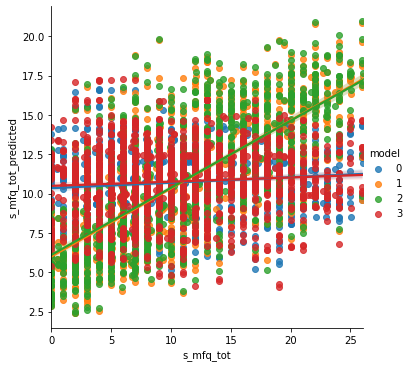

In [26]:
sns.lmplot(x='s_mfq_tot', y='s_mfq_tot_predicted', data=reses, hue='model')

In [27]:
reses.to_csv('../data/mfq_cv_predictions.csv', index=None)

In [28]:
## fit models to everything
model = models[0]
mdl = Lmer(model, mdat)
mdl.fit()


Formula: s_mfq_tot~antidepressants+TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3958.141 	 AIC: 7916.282

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  25.339  5.034
SDAN      TimeBetween  31.179  5.584
Residual               18.805  4.337

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.373

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),21.806,15.366,28.246,3.286,307.770,6.636,0.000,***
antidepressants,-0.041,-2.073,1.992,1.037,115.336,-0.039,0.969,
TimeBetween,-1.190,-2.906,0.526,0.875,75.929,-1.359,0.178,
InpatientDuring,-0.323,-1.357,0.712,0.528,1166.264,-0.612,0.541,
Age_at_visit,-0.557,-0.962,-0.151,0.207,306.549,-2.692,0.008,**
SEX,-3.381,-5.405,-1.357,1.033,116.063,-3.274,0.001,**
OtherMeds,0.614,-1.659,2.886,1.159,113.868,0.529,0.598,
postpandemic,-1.065,-1.909,-0.221,0.431,813.460,-2.473,0.014,*


In [29]:
## fit models to everything
model = models[1]
mdl = Lmer(model, mdat)
mdl.fit()


Formula: s_mfq_tot~antidepressants+TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3777.139 	 AIC: 7554.277

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.217  1.794
SDAN      TimeBetween  12.070  3.474
Residual               16.690  4.085

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.483

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.692,4.134,11.249,1.815,90.787,4.238,0.000,***
antidepressants,0.037,-0.830,0.904,0.442,51.563,0.083,0.934,
TimeBetween,-0.729,-2.059,0.600,0.678,52.647,-1.075,0.287,
MFQtminus1,0.585,0.541,0.628,0.022,583.253,26.253,0.000,***
InpatientDuring,-0.769,-1.650,0.112,0.449,723.206,-1.711,0.087,.
Age_at_visit,-0.159,-0.374,0.056,0.110,79.812,-1.447,0.152,
SEX,-1.346,-2.210,-0.482,0.441,50.099,-3.054,0.004,**
OtherMeds,0.403,-0.561,1.368,0.492,50.757,0.820,0.416,
postpandemic,-0.366,-0.990,0.258,0.318,650.230,-1.149,0.251,


In [30]:
## fit models to everything
model = models[2]
mdl = Lmer(model, mdat)
mdl.fit()


Formula: s_mfq_tot~dep_immed*TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3774.841 	 AIC: 7549.682

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.269  1.808
SDAN      TimeBetween  13.187  3.631
Residual               16.646  4.080

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.482

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.488,3.883,11.093,1.839,92.464,4.071,0.000,***
dep_immed,0.672,-0.387,1.731,0.540,69.203,1.244,0.218,
TimeBetween,-0.319,-2.908,2.270,1.321,45.452,-0.242,0.810,
MFQtminus1,0.581,0.538,0.625,0.022,609.526,26.008,0.000,***
InpatientDuring,-0.772,-1.654,0.110,0.450,735.381,-1.716,0.087,.
Age_at_visit,-0.173,-0.390,0.044,0.111,83.467,-1.566,0.121,
SEX,-1.332,-2.200,-0.463,0.443,51.272,-3.005,0.004,**
antidepressants,0.011,-0.860,0.882,0.444,52.946,0.024,0.981,
OtherMeds,0.389,-0.579,1.358,0.494,52.259,0.788,0.434,
postpandemic,-0.353,-0.979,0.272,0.319,655.301,-1.106,0.269,


In [31]:
## fit models to everything
model = models[3]
mdl = Lmer(model, mdat)
mdl.fit()


Formula: s_mfq_tot~dep_immed*TimeBetween+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3954.906 	 AIC: 7909.813

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  25.151  5.015
SDAN      TimeBetween  32.215  5.676
Residual               18.801  4.336

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.369

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),21.053,14.477,27.628,3.355,285.224,6.275,0.000,***
dep_immed,1.280,-0.928,3.487,1.126,111.068,1.136,0.258,
TimeBetween,-0.993,-4.286,2.300,1.680,67.542,-0.591,0.557,
InpatientDuring,-0.325,-1.360,0.710,0.528,1166.259,-0.616,0.538,
Age_at_visit,-0.568,-0.974,-0.163,0.207,303.175,-2.747,0.006,**
SEX,-3.296,-5.320,-1.272,1.033,114.502,-3.192,0.002,**
antidepressants,-0.098,-2.127,1.931,1.035,113.941,-0.095,0.925,
OtherMeds,0.606,-1.661,2.873,1.157,112.498,0.524,0.602,
postpandemic,-1.049,-1.893,-0.204,0.431,808.576,-2.434,0.015,*
dep_immed:TimeBetween,-0.274,-4.087,3.540,1.946,66.891,-0.141,0.888,
